In [2]:
import pymolpro
import random
import numpy as np
import pandas as pd
import os
import math

#unused
def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

#builds n**3,n**3 array of distance reciprocals
def distances(o1,o2):
    big_arr=np.empty((0,n**3))
    for i in range(len(grid_dt[o1])):
        tmp_list=[]
        for j in range(len(grid_dt[o2])):
            #find the distance
            o1x,o1y,o1z = grid_dt[o1][i]['x'], grid_dt[o1][i]['y'],grid_dt[o1][i]['z']
            o2x,o2y,o2z = grid_dt[o2][j]['x'], grid_dt[o2][j]['y'],grid_dt[o2][j]['z']
            r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
            #correlation energy should scale like r^-6 so take the reciprocal, going to lead to problems at 0 so take an error function
            if r==0:
                w=1
            else:   
                w=(math.erf(a*r)/r)**6
            tmp_list.append(float(w))
        tmp_arr=np.array(tmp_list)
        tmp_arr.reshape((1,len(tmp_list)))
        big_arr=np.vstack((big_arr,tmp_arr))
    
    return big_arr



def orbitalsize(orbital):
    return math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)]))


#build the input array for the ML model
def density_arrays(oid1,oid2):

    
    o1_addft=[float(v) for v in orbital_dt[oid1].values()]
    o2_addft=[float(v) for v in orbital_dt[oid2].values()]

    
    tmp=[float(grid_dt[oid1][i]['d']) for i in range(len(grid_dt[oid1]))]
    tmp=np.array(tmp)
    tmp=np.reshape(tmp,(1,len(grid_dt[oid1])))
    #need all the rows to have the same shape to stack so append 0s
    while len(o1_addft)<n**3:
        o1_addft.append(0)

    #stack to get a (2,n**3) array
    o1_addft=np.array(o1_addft)
    o1_addft=np.reshape(o1_addft,(1,len(grid_dt[oid1])))
    o1_arr=np.vstack((o1_addft,tmp))
    
    #do it all again
    tmp=[grid_dt[oid2][i]['d'] for i in range(len(grid_dt[oid2]))]
    tmp=np.array(tmp)
    tmp=np.reshape(tmp,(1,len(grid_dt[oid2])))
    
    while len(o2_addft)<n**3:
        o2_addft.append(0)
    o2_addft=np.array(o2_addft)
    o2_addft=np.reshape(o2_addft,(1,len(grid_dt[oid2])))
    o2_arr=np.vstack((o2_addft,tmp))

    #returns the (n**3+4,n**3) array of the distance array and the two array of features
    return np.vstack((distances(oid1,oid2),o1_arr,o2_arr))
    


In [2]:
geo_dt={'c2h4':
"""
C       0.04632      0.04634      0.04646
C       0.81955      0.81957      0.81969
H       0.27329     -1.00259     -0.09726
H      -0.82445      0.45146     -0.45360
H       0.59258      1.86847      0.96342
H       1.69029      0.41441      1.31974
""",
'c2h6':
"""
C       0.00000      0.00000      0.00000
C       0.86603      0.86603      0.86603
H      -0.63000     -0.63000      0.63000
H      -0.63000      0.63000     -0.63000
H       0.63000     -0.63000     -0.63000
H       0.23098      1.50113      1.50113
H       1.50113      1.50113      0.23098
H       1.50113      0.23098      1.50113
""",
'ch4':
"""
C       0.00000      0.00000      0.00000
H       0.63000      0.63000      0.63000
H      -0.63000     -0.63000      0.63000
H      -0.63000      0.63000     -0.63000
H       0.63000     -0.63000     -0.63000
""",
'eth':
"""
C      -0.99938      0.05528     -0.19066
H      -1.29704     -0.53094      0.68003
H      -1.80029      0.75402     -0.46015
H      -0.81007     -0.61059     -1.03427
C       0.25224      0.81254      0.13010
O       0.27383      2.00682      0.37623
H       1.17169      0.20423      0.18495
""",
'hcn':
"""
C       0.09831      0.11533      0.10364
N       0.78613      0.74869      0.78990
H      -0.53370     -0.46664     -0.52692
"""}




In [3]:
p_list=[]
for k,v in geo_dt.items():
    p=pymolpro.Project(name=f'{k}')
    p.write_input(f"""
    geometry={{{v}}}
    basis, cc-pvtz
    print orbital
    rhf
    locali, pipek
    mp2
    put, xml
    """)
    print(k)
    p.run(wait=True)
    p_list.append(p)
print(p_list)

c2h4
c2h6
ch4
eth
hcn
[<pymolpro.project.Project object at 0x784beafc4b30>, <pymolpro.project.Project object at 0x784be1bfe960>, <pymolpro.project.Project object at 0x784bea2e2ed0>, <pymolpro.project.Project object at 0x784bea0d36e0>, <pymolpro.project.Project object at 0x784c7c391310>]


In [3]:
p_list=[]
for xyz in os.listdir('/home/stuart/griddistance/xyzfiles'):
    if xyz != '.ipynb_checkpoints':
        p=pymolpro.Project(name=f'{xyz[:-4]}')
        p_list.append(p)

In [4]:
#settings
#grid dimensions
n=4
#alpha in the error function
a=1


corr_list=[]
pair_list=[]

for p in p_list:
    orbital_dt={}
    grid_dt={}
    for orbital in p.orbitals(minocc=1.00):
        points=orbital.grid(n)
        values=orbital.evaluate(points,values=True)
        
        if orbital.ID not in grid_dt:
            grid_dt[orbital.ID] = {}
            grid_dt[f'-{orbital.ID}']={}
        grid_dt[orbital.ID].update({i:{'x':points[i][0],
                                       'y':points[i][1],
                                       'z':points[i][2],
                                       'd':values[i]
        }for i in range(len(points))})
        orbital_dt.update({orbital.ID:{
        'energy':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
        'size':float(orbitalsize(orbital)),
            'spin':1,
            'ke':float(orbital.kinetic_energy)
        }})
        oid=f'-{orbital.ID}'
        grid_dt[oid].update({i:{'x':points[i][0],
                                       'y':points[i][1],
                                       'z':points[i][2],
                                       'd':values[i]
        }for i in range(len(points))})
        orbital_dt.update({oid:{
        'energy':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
        'size':float(orbitalsize(orbital)),
            'spin':-1,
            'ke':float(orbital.kinetic_energy)
        }})
        

    for pair in p.xpath("//pair"):

        tmp=pymolpro.element_to_dict(pair)
        corr_list.append(float(tmp['energy']))
        
        densitymap=density_arrays(tmp['orbital1'],tmp['orbital2'])
        pair_list.append(densitymap)
        

pair_arr=np.stack(pair_list)
print(len(corr_list))
print(pair_arr[0])

414
[[ 1.          1.38171045  0.56270544 ...  0.02077165  0.01422411
   0.00762155]
 [ 1.38171045  1.          1.52928893 ...  0.02452714  0.02166605
   0.01422411]
 [ 0.56270544  1.52928893  1.         ...  0.02166605  0.02452714
   0.02077165]
 ...
 [ 0.16647946  0.18759947  0.19909407 ...  0.18759947  0.19909407
   0.20168504]
 [-0.941924    1.89115967 -1.         ...  0.          0.
   0.        ]
 [ 0.16647946  0.18759947  0.19909407 ...  0.18759947  0.19909407
   0.20168504]]


(414, 68, 64)
(414,)
Epoch 1/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 102060.6953 - mean_absolute_error: 2.7608 - mean_squared_error: 25.9546
Epoch 2/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 45553.7227 - mean_absolute_error: 0.9582 - mean_squared_error: 1.5242
Epoch 3/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 26453.6523 - mean_absolute_error: 0.5141 - mean_squared_error: 0.5098
Epoch 4/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 23881.9746 - mean_absolute_error: 0.4726 - mean_squared_error: 0.3562
Epoch 5/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 18871.5957 - mean_absolute_error: 0.4549 - mean_squared_error: 0.3189
Epoch 6/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 12019.3037 - mean_absolute_error: 0.2577 - mean_squared_error: 0.1156
Epoch 7/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 12991.4893 - mean_absolute_error: 0.3346 - mean_squared_error: 0.1985
Epoch 8/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 935u

2024-07-25 14:48:41.716557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


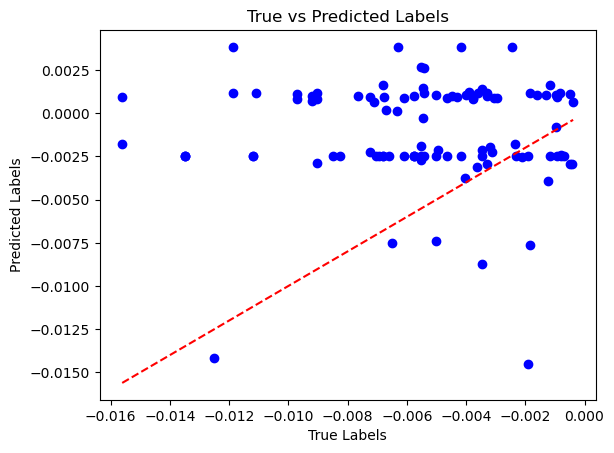

In [17]:
import tensorflow as tf
import keras

#settings

#test set size
test_ratio=0.25

#batch size
batch_size =1



train_ratio=1-test_ratio
train_size=int(train_ratio*len(corr_list))

features=pair_arr
print(features.shape)
labels=np.array(corr_list)
print(labels.shape)


dataset=tf.data.Dataset.from_tensor_slices((features,labels))
dataset = dataset.shuffle(buffer_size=len(corr_list)//4)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


inp_shape=(n**3+4,n**3)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=inp_shape),
    keras.layers.Dense(1028, activation='sigmoid'),
    keras.layers.Dense(1,)  
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=['mean_absolute_error', 'mean_squared_error'])
model.fit(train_dataset,epochs=100)
model.evaluate(test_dataset)

model.save('new.keras')

predictions = model.predict(test_dataset)

import matplotlib as mpl
import matplotlib.pyplot as plt

test_labels = []
for features, labels in test_dataset:
    test_labels.append(labels.numpy())
test_labels = np.concatenate(test_labels, axis=0)
plt.scatter(test_labels, predictions, c='blue')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Line for y=x
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Labels')
plt.show()

In [28]:
print(predictions)

[[0.01019774]
 [0.01195163]
 [0.00914434]
 [0.0076038 ]
 [0.00759391]
 [0.00760078]
 [0.01120191]
 [0.00759391]
 [0.00763384]
 [0.00759391]
 [0.01077201]
 [0.00759391]
 [0.00759391]
 [0.00759391]
 [0.00596099]
 [0.00759391]
 [0.01151232]
 [0.00759391]
 [0.01077134]
 [0.00759391]
 [0.00914613]
 [0.00759391]
 [0.00759391]
 [0.01145733]
 [0.01085819]
 [0.01175214]
 [0.00760498]
 [0.01110703]
 [0.00759391]
 [0.006635  ]
 [0.00954542]
 [0.00723878]
 [0.01145075]
 [0.00678364]
 [0.01189751]
 [0.01076915]
 [0.00762286]
 [0.00759391]
 [0.01167101]
 [0.01007005]
 [0.00759391]
 [0.00759391]
 [0.00708873]
 [0.00720672]
 [0.00606277]
 [0.00759391]
 [0.00759391]
 [0.00771549]
 [0.00759391]
 [0.01105312]
 [0.01193763]
 [0.00859372]
 [0.01127984]
 [0.00759391]
 [0.01036959]
 [0.01053099]
 [0.00759391]
 [0.01106358]
 [0.01114195]
 [0.01041172]
 [0.01044952]
 [0.01205388]
 [0.00759391]
 [0.00761471]
 [0.00759391]
 [0.01144914]
 [0.00759391]
 [0.01065887]
 [0.01038519]
 [0.00759391]
 [0.01120409]
 [0.00

In [18]:
import keras_tuner
import keras
from keras.layers import Dense, InputLayer

def build_model(hp):
 
  model = keras.Sequential()
  model.add(InputLayer(shape=inp_shape))
  model.add(keras.layers.Dense(
       units=hp.Int("units", min_value=32, max_value=512, step=32),
            
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile( optimizer='adam',
        loss='mse',
        metrics=['mae'])
  return model
    
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory="/tmp/tb")
    
tuner.search(train_dataset, epochs=50, validation_data=test_dataset)
best_model = tuner.get_best_models()[0]


Reloading Tuner from /tmp/tb/untitled_project/tuner0.json
